In [9]:
# # Constant viscosity convection, Cartesian domain (benchmark)
#
#
#
# This example solves 2D dimensionless isoviscous thermal convection with a Rayleigh number, for comparison with the [Blankenbach et al. (1989) benchmark](https://academic.oup.com/gji/article/98/1/23/622167).
#
# We set up a v, p, T system in which we will solve for a steady-state T field in response to thermal boundary conditions and then use the steady-state T field to compute a stokes flow in response.

# +tolerace
import os
os.environ["UW_TIMING_ENABLE"] = "1"
import petsc4py
from petsc4py import PETSc


import underworld3 as uw
from underworld3.systems import Stokes
from underworld3 import function

import numpy as np
import sympy


In [10]:
# +
##### Set some things
Ra = 1e4 #### Rayleigh number
eta0=1.e23

k = 1.0 #### diffusivity

res= 16 ### x and y res of box

boxLength = 1.0
boxHeight = 1.0
tempMin   = 0.
tempMax   = 1.

viscosity = 1

# +
meshbox = uw.meshing.UnstructuredSimplexBox(
    minCoords=(0.0, 0.0), maxCoords=(1.0, 1.0), cellSize=1.0 / res, regular=False, qdegree=3
)

Processing gmsh file .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.0625_regFalse.msh
Mesh saved to .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.0625_regFalse.msh.h5


In [11]:
#infile = "/Users/jcgraciosa/Documents/codes/uw3-dev/dummy/convection_96"
#infile = "/Users/jcgraciosa/Documents/codes/uw3-dev/Blankenbach_out_run2/convection_48"
infile = "/Users/jcgraciosa/Documents/codes/uw3-dev/kaiju-out/convection_48"
v_soln = uw.discretisation.MeshVariable("U", meshbox, meshbox.dim, degree=2)
p_soln = uw.discretisation.MeshVariable("P", meshbox, 1, degree=1)
t_soln = uw.discretisation.MeshVariable("T", meshbox, 1, degree=3)

v_soln.load_from_h5_plex_vector(infile + '.U.0.h5')
p_soln.load_from_h5_plex_vector(infile + '.P.0.h5')
t_soln.load_from_h5_plex_vector(infile + '.T.0.h5')

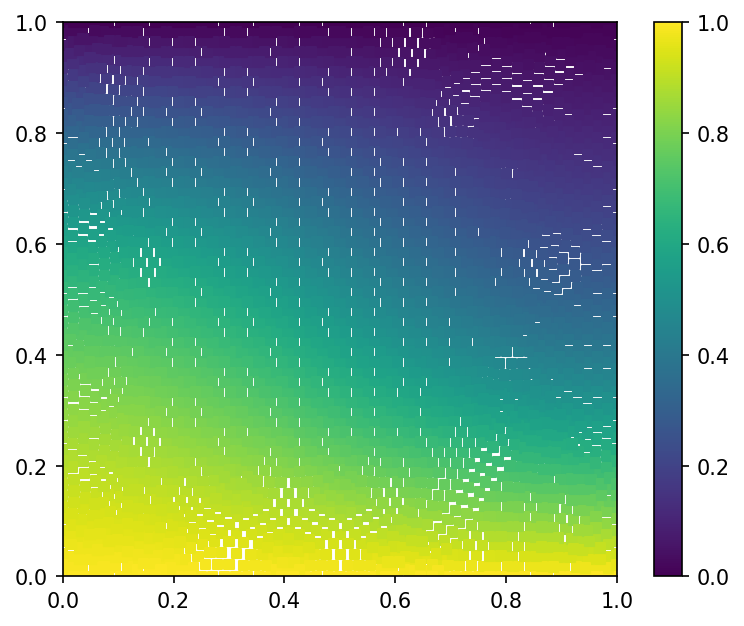

In [17]:
import matplotlib.pyplot as plt
with meshbox.access():
    fig, ax = plt.subplots(dpi = 150)
    out = ax.scatter(t_soln.coords[:, 0], t_soln.coords[:, 1], c = t_soln.data[:], marker = "s", s = 20)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)

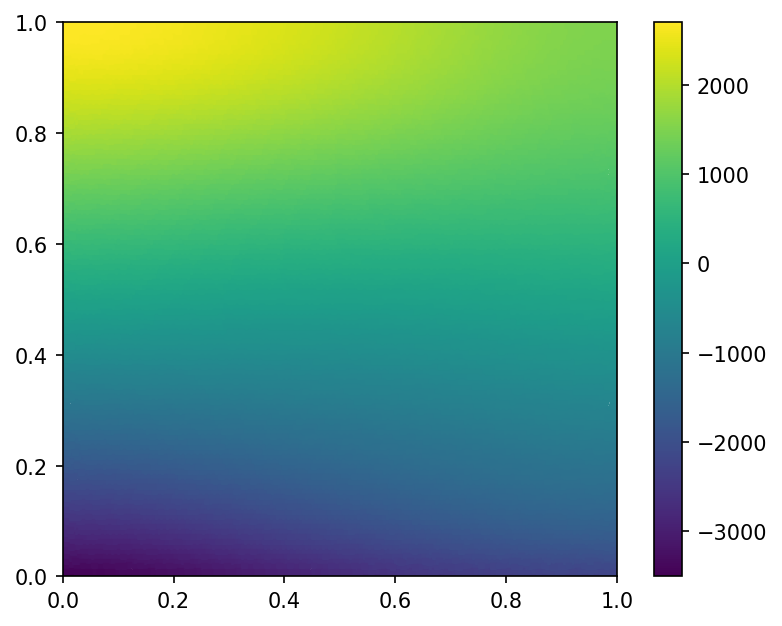

In [7]:
import matplotlib.pyplot as plt
with meshbox.access():
    fig, ax = plt.subplots(dpi = 150)
    out = ax.scatter(p_soln.coords[:, 0], p_soln.coords[:, 1], c = p_soln.data[:], marker = "s", s = 5)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)

In [9]:
# interpolate the variables from the low res model to the high res model
with meshbox_hr.access(v_soln_hr, t_soln_hr, p_soln_hr):
    
    # use nearest-neighbord workaround
    t_soln_hr.data[:] = nearest_neigh_workaround(meshbox, meshbox_hr, t_soln, t_soln_hr)
    p_soln_hr.data[:] = nearest_neigh_workaround(meshbox, meshbox_hr, p_soln, p_soln_hr)
    v_soln_hr.data[:] = nearest_neigh_workaround(meshbox, meshbox_hr, v_soln, v_soln_hr)

    # NOTE: something is weird when using the uw.function.evaluate with quad elements
    # t_soln_hr.data[:, 0] = uw.function.evaluate(t_soln.sym[0], t_soln_hr.coords)
    # p_soln_hr.data[:, 0] = uw.function.evaluate(p_soln.sym[0], p_soln_hr.coords)

    # #for velocity, encounters errors when trying to interpolate in the non-zero boundaries of the mesh variables 
    # v_coords = deepcopy(v_soln_hr.coords)

    # cond = v_coords[:, 0] == boxLength      # v_x
    # v_coords[cond, 0] = 0.999999*boxLength 
    
    # cond = v_coords[:, 1] == boxHeight      # v_y
    # v_coords[cond, 1] = 0.999999*boxHeight 

    # v_soln_hr.data[:] = uw.function.evaluate(v_soln.fn, v_coords)

    # final set-up of other variables
    buoyancy_force = Ra * t_soln_hr.sym[0]
    stokes_hr.bodyforce = sympy.Matrix([0, buoyancy_force])

    adv_diff_hr.petsc_options["pc_gamg_agg_nsmooths"] = 5


  0 SNES Function norm 0.0156898 
  1 SNES Function norm 1.68536e-06 
  2 SNES Function norm < 1.e-11
Nonlinear SProj_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2


In [10]:
test = uw.function.evaluate(dTdZ.sym[0], meshbox.data)
test2 = uw.function.evaluate(t_soln.sym[0], meshbox.data)
print(test.shape)
print(test.min())
print(test.max())
print(test2.shape)
print(test2.min())
print(test2.max())

(4225,)
-1.463920688979215
-0.6875312555715922
(4225,)
-0.287738398193909
1.2909588506012986


In [11]:
with meshbox.access():
    x = meshbox.data[:, 0]
    y = meshbox.data[:, 1]
    print(meshbox.data.shape)
    print(v_soln.data.shape)
    print(t_soln.coords.shape)
    print(dTdZ.coords.shape)
    print(meshbox._centroids.shape[0])

(4225, 2)
(16641, 2)
(4225, 2)
(4225, 2)
4096


In [12]:
try:
    with meshbox.access():
        print(np.allclose(t_soln.coords[:, 0], v_soln.coords[:, 0]))
        print(np.allclose(t_soln.coords[:, 1], v_soln.coords[:, 1]))
except:
    print("Lengths differ ...")

Lengths differ ...


In [13]:
with meshbox.access():
    a = uw.function.evaluate(t_soln.sym[0], meshbox.data)
    b = uw.function.evaluate(t_soln.fn, meshbox.data)
    print(np.allclose(a, b))

True


In [14]:
# +
# check the mesh if in a notebook / serial

def plotFig(is_grad = False):
    
    if uw.mpi.size == 1:

        import numpy as np
        import pyvista as pv
        import vtk

        pv.global_theme.background = "white"
        pv.global_theme.window_size = [750, 250]
        pv.global_theme.antialiasing = True
        pv.global_theme.jupyter_backend = "panel"
        pv.global_theme.smooth_shading = True

        meshbox.vtk("tmp_box_mesh.vtk")
        pvmesh = pv.read("tmp_box_mesh.vtk")

        velocity = np.zeros((meshbox.data.shape[0], 3))
        velocity[:, 0] = uw.function.evaluate(v_soln.sym[0], meshbox.data)
        velocity[:, 1] = uw.function.evaluate(v_soln.sym[1], meshbox.data)

        pvmesh.point_data["V"] = velocity / 10

        # old code
        points = np.zeros((t_soln.coords.shape[0], 3))
        points[:, 0] = t_soln.coords[:, 0]
        points[:, 1] = t_soln.coords[:, 1]

        point_cloud = pv.PolyData(points)

        #grad_out = uw.function.evaluate(dTdZ.sym[0], meshbox.data)
    
        with meshbox.access():
            if not is_grad:
                point_cloud.point_data["Tp"] = t_soln.data.copy() # uw.function.evaluate(t_soln.sym[0], meshbox.data)
            else: # gradient
                point_cloud.point_data["Tp"] = dTdZ.data.copy()

        # point sources at cell centres

        cpoints = np.zeros((meshbox._centroids.shape[0] // 4, 3))
        cpoints[:, 0] = meshbox._centroids[::4, 0]
        cpoints[:, 1] = meshbox._centroids[::4, 1]

        cpoint_cloud = pv.PolyData(cpoints)

        pvstream = pvmesh.streamlines_from_source(
            cpoint_cloud,
            vectors="V",
            integrator_type=2,
            integration_direction="forward",
            compute_vorticity=False,
            max_steps=1000,
            surface_streamlines=True,
        )

        
        
        with meshbox.access():
            if not is_grad:
                pvmesh.point_data["T"] = t_soln.data
                #pvmesh.point_data["T"] = uw.function.evaluate(t_soln.fn, meshbox.data) # t_soln.fn is same as t_soln.sym[0]
            else:
             pvmesh.point_data["T"] = dTdZ.data


        pl = pv.Plotter()

        # pl.add_mesh(pvmesh,'Gray', 'wireframe')

        # pl.add_mesh(
        #     pvmesh, cmap="coolwarm", edge_color="Black",
        #     show_edges=True, scalars="T", use_transparency=False, opacity=0.5,
        # )

        pl.add_points(point_cloud, cmap="coolwarm", render_points_as_spheres=True, point_size=10, opacity=0.33)

        #pl.add_mesh(pvstream, opacity=0.5)
        # pl.add_arrows(arrow_loc2, arrow_length2, mag=1.0e-1)

        # pl.add_points(pdata)

        pl.show(cpos="xy")
        pvmesh.clear_data()
        pvmesh.clear_point_data()
        

# -

In [15]:
#plotFig()

In [16]:
#plotFig(is_grad = True)

In [17]:
buoyancy_force = Ra * t_soln.sym[0]
stokes.bodyforce = sympy.Matrix([0, buoyancy_force])

adv_diff.petsc_options["pc_gamg_agg_nsmooths"] = 5

# +
def v_rms():
    v_rms = math.sqrt(uw.maths.Integral(meshbox, v_soln.fn.dot(v_soln.fn)).evaluate())
    return v_rms

print(f'initial v_rms = {v_rms()}')



initial v_rms = 0.0


In [18]:

# -

def plot_T_mesh(filename):

    if uw.mpi.size == 1:

        import numpy as np
        import pyvista as pv
        import vtk

        pv.global_theme.background = "white"
        pv.global_theme.window_size = [750, 750]
        pv.global_theme.antialiasing = True
        pv.global_theme.jupyter_backend = "pythreejs"
        pv.global_theme.smooth_shading = True
        pv.global_theme.camera["viewup"] = [0.0, 1.0, 0.0]
        pv.global_theme.camera["position"] = [0.0, 0.0, 5.0]

        meshbox.vtk("tmp_box_mesh.vtk")
        pvmesh = pv.read("tmp_box_mesh.vtk")

        velocity = np.zeros((meshbox.data.shape[0], 3))
        velocity[:, 0] = uw.function.evaluate(v_soln.sym[0], meshbox.data)
        velocity[:, 1] = uw.function.evaluate(v_soln.sym[1], meshbox.data)

        pvmesh.point_data["V"] = velocity / 333
        pvmesh.point_data["T"] = uw.function.evaluate(t_soln.fn, meshbox.data)

        # point sources at cell centres

        cpoints = np.zeros((meshbox._centroids.shape[0] // 4, 3))
        cpoints[:, 0] = meshbox._centroids[::4, 0]
        cpoints[:, 1] = meshbox._centroids[::4, 1]
        cpoint_cloud = pv.PolyData(cpoints)

        pvstream = pvmesh.streamlines_from_source(
            cpoint_cloud,
            vectors="V",
            integrator_type=45,
            integration_direction="forward",
            compute_vorticity=False,
            max_steps=25,
            surface_streamlines=True,
        )

        points = np.zeros((t_soln.coords.shape[0], 3))
        points[:, 0] = t_soln.coords[:, 0]
        points[:, 1] = t_soln.coords[:, 1]

        point_cloud = pv.PolyData(points)

        with meshbox.access():
            point_cloud.point_data["T"] = t_soln.data.copy()

        pl = pv.Plotter()

        pl.add_mesh(
            pvmesh,
            cmap="coolwarm",
            edge_color="Gray",
            show_edges=True,
            scalars="T",
            use_transparency=False,
            opacity=0.5,
        )

        pl.add_points(point_cloud, cmap="coolwarm", render_points_as_spheres=False, point_size=10, opacity=0.5)

        pl.add_mesh(pvstream, opacity=0.4)

        pl.remove_scalar_bar("T")
        pl.remove_scalar_bar("V")

        pl.screenshot(filename="{}.png".format(filename), window_size=(1280, 1280), return_img=False)
        # pl.show()
        pl.close()

        pvmesh.clear_data()
        pvmesh.clear_point_data()

        pv.close_all()



In [19]:
# opt_dict = adv_diff.petsc_options.getAll()
# for key in opt_dict.keys():
#     print(key, ": ", opt_dict[key])

In [20]:
# opt_dict = stokes.petsc_options.getAll()
# for key in opt_dict.keys():
#     print(key, ": ", opt_dict[key])

In [21]:

# +
t_step = 0
time = 0.

nsteps = 100

timeVal =  np.zeros(nsteps)*np.nan
vrmsVal =  np.zeros(nsteps)*np.nan

# +
#### Convection model / update in time

"""
There is a strange interaction here between the solvers if the zero_guess is set to False
"""

# expt_name = "output/Ra1e6"

uw.timing.start()
while t_step < nsteps:
    vrmsVal[t_step] = v_rms()
    timeVal[t_step] = time

    stokes.solve(zero_init_guess=True) # originally True
    delta_t = 0.5 * stokes.estimate_dt()
    adv_diff.solve(timestep=delta_t, zero_init_guess=False) # originally False

    # stats then loop
    tstats = t_soln.stats()

    if uw.mpi.rank == 0 and t_step % 20 == 0: 
        print("Timestep {}, dt {}".format(t_step, delta_t))
        
        print(f't_rms = {t_soln.stats()[6]}, v_rms = {v_rms()}')

    # if t_step % 5 == 0:
    #     plot_T_mesh(filename="{}_step_{}".format(expt_name, t_step))

    t_step += 1
    time   += delta_t

uw.timing.stop()
# savefile = "{}_ts_{}.h5".format(expt_name,step)
# meshbox.save(savefile)
# v_soln.save(savefile)
# t_soln.save(savefile)
# meshbox.generate_xdmf(savefile)

# -


#plotFig()



  0 SNES Function norm 50.1473 
  1 SNES Function norm 0.000890255 
Nonlinear stokes_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.258581 
  1 SNES Function norm 2.58289e-06 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
Timestep 0, dt 0.0001542282894145279
t_rms = 0.5812814202626795, v_rms = 17.90403285528801
  0 SNES Function norm 50.1271 
  1 SNES Function norm 0.000215333 
Nonlinear stokes_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.24085 
  1 SNES Function norm 1.00403e-06 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 50.1051 
  1 SNES Function norm 0.000885488 
Nonlinear stokes_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.222335 
  1 SNES Function norm 1.08673e-06 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function n

KeyboardInterrupt: 

Exception ignored in: 'petsc4py.PETSc.PetscVFPrintf_PythonStd'
Traceback (most recent call last):
  File "/Users/jgra0019/mambaforge/envs/uw3/lib/python3.10/site-packages/ipykernel/iostream.py", line 535, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 


In [2]:
uw.timing.print_table()

NameError: name 'uw' is not defined

In [ ]:
del os.environ["UW_TIMING_ENABLE"]

In [ ]:
# first solution tested
# t_soln_grad = meshbox.vector.gradient(t_soln.sym)
# display(t_soln_grad[1])
# uw.function.evaluate(t_soln_grad[0], meshbox.data)

# second solution - create a projector system
t_soln_grad.solve()

  0 SNES Function norm 0.0150739 
  1 SNES Function norm 1.73534e-06 
  2 SNES Function norm 1.603e-11 
Nonlinear SProj_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2


In [ ]:
#plotFig(is_grad = True)

/Users/jgra0019/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2489: PyVistaDeprecationWarning: antialising is deprecated.  Please use `anti_aliasing` instead.
  warnings.warn(
/Users/jgra0019/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2457: PyVistaDeprecationWarning: `anti_aliasing` is now a string or None and must be either "ssaa", "msaa", "fxaa", or None
  warnings.warn(


/var/folders/sj/jbtsvyqn1d556dgk71dlv3_x665gb7/T/ipykernel_87247/1581495046.py:15: PyVistaDeprecationWarning: `panel` backend is deprecated and is planned for future removal.
  pv.global_theme.jupyter_backend = "panel"


BokehModel(combine_events=True, render_bundle={'docs_json': {'22d36614-63ab-46a7-b2da-e447720a0e80': {'defs': …

In [ ]:
#plotFig(is_grad = False)

/Users/jgra0019/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2489: PyVistaDeprecationWarning: antialising is deprecated.  Please use `anti_aliasing` instead.
  warnings.warn(
/Users/jgra0019/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/themes.py:2457: PyVistaDeprecationWarning: `anti_aliasing` is now a string or None and must be either "ssaa", "msaa", "fxaa", or None
  warnings.warn(


/var/folders/sj/jbtsvyqn1d556dgk71dlv3_x665gb7/T/ipykernel_87247/1581495046.py:15: PyVistaDeprecationWarning: `panel` backend is deprecated and is planned for future removal.
  pv.global_theme.jupyter_backend = "panel"


BokehModel(combine_events=True, render_bundle={'docs_json': {'615cbd8d-111e-4fa4-8798-efa23f62748d': {'defs': …

# Calculate benchmark values

In [ ]:
# show the last v_rms value
vrmsVal[-1]

19.81799244955376

In [5]:
# function for calculating the surface integral 
# from Ex_Shear_Band_Notch_Benchmark
 
def surface_integral(mesh, uw_function, mask_fn):

    calculator = uw.maths.Integral(mesh, uw_function * mask_fn)
    value = calculator.evaluate()

    calculator.fn = mask_fn
    norm = calculator.evaluate()

    integral = value / norm

    return integral

In [6]:
# define upper and lower surface functions
x, z = meshbox.X

up_surface_defn_fn = sympy.exp(-1e4*((z - 1)**2)) # at z = 1
lw_surface_defn_fn = sympy.exp(-1e4*((z)**2)) # at z = 0

display(up_surface_defn_fn)
display(lw_surface_defn_fn)

exp(-10000.0*(N0.y - 1)**2)

exp(-10000.0*N0.y**2)

In [7]:
# calculate the surface integral for both upper and lower surfaces

up_int = surface_integral(meshbox, dTdZ.sym[0], up_surface_defn_fn)
lw_int = surface_integral(meshbox, t_soln.sym[0], lw_surface_defn_fn)

Nu = -up_int/lw_int

print(Nu)

NameError: name 'dTdZ' is not defined

In [ ]:
# calculate q values which depend onn the temperature gradient fields

q1 = -uw.function.evaluate(dTdZ.sym[0], np.array([[0., 0.999999*boxHeight]]))[0]
q2 = -uw.function.evaluate(dTdZ.sym[0], np.array([[0.999999*boxLength, 0.999999*boxHeight]]))[0]
q3 = -uw.function.evaluate(dTdZ.sym[0], np.array([[0.999999*boxLength, 0.]]))[0]
q4 = -uw.function.evaluate(dTdZ.sym[0], np.array([[0., 0.]]))[0]

if(uw.mpi.rank==0):
    print('Rayleigh number = {0:.1e}'.format(Ra))
    print('q1 = {0:.3f}; q2 = {1:.3f}'.format(q1, q2))
    print('q3 = {0:.3f}; q4 = {1:.3f}'.format(q3, q4))

Rayleigh number = 1.0e+04
q1 = 0.665; q2 = 0.310
q3 = 0.665; q4 = 0.310


In [ ]:
# projection for the stress in the zz direction
x, y = meshbox.X

stress_calc = uw.systems.Projection(meshbox, sigma_zz)
stress_calc.uw_function = stokes.stress[1, 1]
stress_calc.smoothing = 1.0e-3
stress_calc.petsc_options.delValue("ksp_monitor")

In [ ]:
stress_calc.solve()

  0 SNES Function norm 7790.04 
  1 SNES Function norm 0.842055 
  2 SNES Function norm 8.29869e-06 
Nonlinear SProj_2_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 2


In [ ]:
# subtract the average value for the benchmark 

mean_sigma_zz_top = surface_integral(meshbox, 
                                     sigma_zz.sym[0], 
                                     up_surface_defn_fn)/boxLength


In [ ]:
with meshbox.access():
    cond = meshbox.data[:, 1] == meshbox.data[:, 1].max()
    up_surface_coords = meshbox.data[cond]
    up_surface_coords[:, 1] = 0.999999*up_surface_coords[:, 1] 

sigma_zz_top = -uw.function.evaluate(sigma_zz.sym[0], up_surface_coords) - mean_sigma_zz_top

In [ ]:
# Set parameters in SI units

grav = 10        # m.s^-2
height = 1.e6    # m 
rho  = 4.0e3     # g.m^-3
kappa  = 1.0e-6  # m^2.s^-1

eta0=1.e23

# dimensionalise 
dim_sigma_zz_top  = (eta0 * kappa / (height*height)) * sigma_zz_top
topography = dim_sigma_zz_top / (rho * grav) 


In [ ]:
D = np.array([
            [1, 0, 0, 0],
            [0, 3, 0, 0],
            [0, 0, 2, 0],
            [0, 0, 0, 2]])
A = np.array([
            [1, 1, 0, 0],
            [1, 1, 1, 1],
            [0, 1, 1, 1],
            [0, 1, 1 ,1]
])

D_sqrt = 1/np.sqrt(D)


array([2521603.7827761 , 2519815.39993392, 2519816.48376288,
       2519819.72335905, 2519825.10981899, 2519832.63142466,
       2519842.26757673, 2519853.9972144 , 2519867.78977975,
       2519883.61430138, 2519903.32819972, 2519923.04209805,
       2519944.65334746, 2519968.10978741, 2519993.35447463,
       2520020.32723112, 2520048.9625088 , 2520079.19183261,
       2520110.94208188, 2520144.13640931, 2520178.695514  ,
       2520214.53534869, 2520251.57046541, 2520289.71081522,
       2520328.86518424, 2520368.9388566 , 2520409.8356156 ,
       2520451.45673968, 2520493.70217954, 2520536.47007401,
       2520579.6577051 , 2520623.16105318, 2520666.87575339,
       2520710.69609903, 2520754.51709692, 2520798.23235501,
       2520841.73737595, 2520884.92638817, 2520927.69579512,
       2520969.94194085, 2521011.56362049, 2521052.46009393,
       2521092.53340303, 2521131.68627748, 2521169.8252176 ,
       2521206.85769195, 2521242.69488248, 2521277.25036496,
       2521310.44104245,